In [502]:
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import warnings
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

In [503]:
ticker = "HDFCLIFE.NS"
# ticker='TCS.NS'
sp500 = yf.Ticker(ticker)
sp500 = sp500.history(period="max")  # You can change the period as needed


In [504]:

sp500.index

DatetimeIndex(['2017-11-17 00:00:00+05:30', '2017-11-20 00:00:00+05:30',
               '2017-11-21 00:00:00+05:30', '2017-11-22 00:00:00+05:30',
               '2017-11-23 00:00:00+05:30', '2017-11-24 00:00:00+05:30',
               '2017-11-27 00:00:00+05:30', '2017-11-28 00:00:00+05:30',
               '2017-11-29 00:00:00+05:30', '2017-11-30 00:00:00+05:30',
               ...
               '2024-06-07 00:00:00+05:30', '2024-06-10 00:00:00+05:30',
               '2024-06-11 00:00:00+05:30', '2024-06-12 00:00:00+05:30',
               '2024-06-13 00:00:00+05:30', '2024-06-14 00:00:00+05:30',
               '2024-06-18 00:00:00+05:30', '2024-06-19 00:00:00+05:30',
               '2024-06-20 00:00:00+05:30', '2024-06-21 00:00:00+05:30'],
              dtype='datetime64[ns, Asia/Kolkata]', name='Date', length=1626, freq=None)

In [505]:
sp500.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')

<Axes: xlabel='Date'>

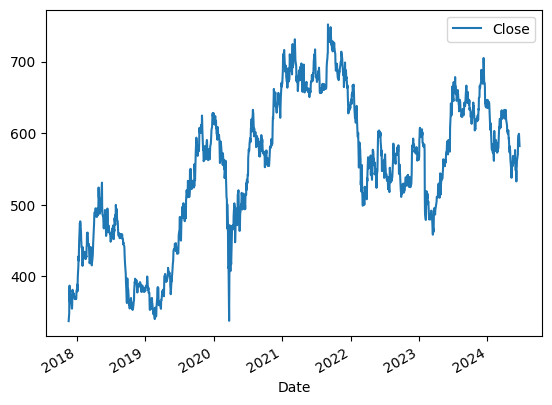

In [506]:
sp500.plot.line(y='Close', use_index=True)

In [507]:
sp500=sp500.drop(columns=['Dividends', 'Stock Splits'])

In [508]:
sp500.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

### We took the shift Column and we took the price back 1 day.

In [509]:
sp500['Tomorrow'] = sp500['Close'].shift(-1)

In [510]:
sp500

,Open,High,Low,Close,Volume,Tomorrow
Date,,,,,,
2017-11-17 00:00:00+05:30,303.729035,361.535528,300.789721,337.629120,168836552,348.161652
2017-11-20 00:00:00+05:30,337.727096,351.639827,337.041244,348.161652,14650240,377.505798
2017-11-21 00:00:00+05:30,349.190419,410.426114,345.369318,377.505798,43078194,387.205566
2017-11-22 00:00:00+05:30,380.151202,399.746625,379.073448,387.205566,15227642,367.267242
2017-11-23 00:00:00+05:30,382.110770,384.070313,363.593100,367.267242,12300150,363.201202
...,...,...,...,...,...,...
2024-06-14 00:00:00+05:30,597.119359,599.760341,592.036607,596.322021,7308942,599.162415
2024-06-18 00:00:00+05:30,594.827121,602.949523,589.794249,599.162415,5120280,594.179321
2024-06-19 00:00:00+05:30,600.059288,603.098999,590.342334,594.179321,4453729,588.099976


In [511]:
sp500['Target'] = (sp500["Tomorrow"] > sp500['Close']).astype(int)

In [512]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
2017-11-17 00:00:00+05:30,303.729035,361.535528,300.789721,337.629120,168836552,348.161652,1
2017-11-20 00:00:00+05:30,337.727096,351.639827,337.041244,348.161652,14650240,377.505798,1
2017-11-21 00:00:00+05:30,349.190419,410.426114,345.369318,377.505798,43078194,387.205566,1
2017-11-22 00:00:00+05:30,380.151202,399.746625,379.073448,387.205566,15227642,367.267242,0
2017-11-23 00:00:00+05:30,382.110770,384.070313,363.593100,367.267242,12300150,363.201202,0
...,...,...,...,...,...,...,...
2024-06-14 00:00:00+05:30,597.119359,599.760341,592.036607,596.322021,7308942,599.162415,1
2024-06-18 00:00:00+05:30,594.827121,602.949523,589.794249,599.162415,5120280,594.179321,0
2024-06-19 00:00:00+05:30,600.059288,603.098999,590.342334,594.179321,4453729,588.099976,0


In [513]:
sp500 = sp500.loc['1990-01-01':].copy()
sp500 = sp500.loc[:'2022-05-18'].copy()

In [514]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
2017-11-17 00:00:00+05:30,303.729035,361.535528,300.789721,337.629120,168836552,348.161652,1
2017-11-20 00:00:00+05:30,337.727096,351.639827,337.041244,348.161652,14650240,377.505798,1
2017-11-21 00:00:00+05:30,349.190419,410.426114,345.369318,377.505798,43078194,387.205566,1
2017-11-22 00:00:00+05:30,380.151202,399.746625,379.073448,387.205566,15227642,367.267242,0
2017-11-23 00:00:00+05:30,382.110770,384.070313,363.593100,367.267242,12300150,363.201202,0
...,...,...,...,...,...,...,...
2022-05-12 00:00:00+05:30,554.813906,559.321013,539.163034,542.085205,3079554,545.552124,1
2022-05-13 00:00:00+05:30,549.762013,560.509589,542.877594,545.552124,3154166,544.512085,0
2022-05-16 00:00:00+05:30,546.889398,552.486099,539.063993,544.512085,1260662,549.613403,1


## Random forest Classifier

In [515]:
model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

In [516]:
train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

In [517]:
sp500.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Tomorrow', 'Target'], dtype='object')

In [518]:
features=['Close','Volume','Open','High','Low']

# Extract features and target for training
X_train = train[features]
y_train = train['Target']

# Extract features and target for testing
X_test = test[features]
y_test = test['Target']

In [519]:


model.fit(X_train,y_train)

RandomForestClassifier(min_samples_split=100, random_state=1)

### Predict Data

In [520]:
from sklearn.metrics import precision_score

preds = model.predict(test[features])

In [521]:
preds = pd.Series(preds,index=test.index)


In [522]:
preds

Date
2021-12-22 00:00:00+05:30    1
2021-12-23 00:00:00+05:30    1
2021-12-24 00:00:00+05:30    0
2021-12-27 00:00:00+05:30    0
2021-12-28 00:00:00+05:30    1
                            ..
2022-05-12 00:00:00+05:30    1
2022-05-13 00:00:00+05:30    1
2022-05-16 00:00:00+05:30    1
2022-05-17 00:00:00+05:30    1
2022-05-18 00:00:00+05:30    1
Length: 100, dtype: int64

In [523]:
precision_score(y_test,preds)

np.float64(0.46875)

In [524]:
combined = pd.concat([y_test,preds],axis=1)


<Axes: xlabel='Date'>

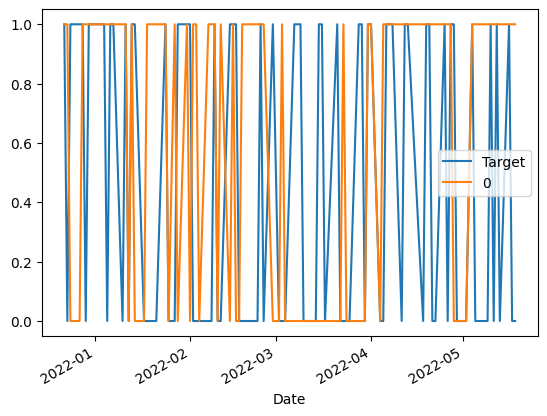

In [525]:
combined.plot()

In [526]:
def predict(train, test, features, model):
    model.fit(train[features], train['Target'])
    preds = model.predict(test[features])
    preds = pd.Series(preds, index=test.index, name='Predictions')
    
    combined = pd.concat([test['Target'], preds], axis=1)
    return combined

In [527]:
def backtest(data, model, features, start=2500, step=250):
    all_predictions = []
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, features, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

In [528]:
predictions = backtest(sp500, model, features)

ValueError: No objects to concatenate

In [ ]:
predictions['Predictions'].value_counts()

In [ ]:
precision_score(predictions['Target'], predictions['Predictions'])

In [ ]:
predictions['Target'].value_counts()/predictions.shape[0]

#### Mean of closed price of several days and years

In [ ]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()

    ratio_column = f"Close_Ratio_{horizon}"
    # sp500[ratio_columns] = sp500['Close']/rolling_averages["Close"]
    sp500[ratio_column] = sp500['Close'] / rolling_averages['Close']

    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()['Target']

    new_predictors += [ratio_column, trend_column]
    
    

In [ ]:
sp500

In [ ]:
sp500  = sp500.dropna()

In [ ]:
sp500

In [ ]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [ ]:
def predict(train, test, features, model):
    model.fit(train[features], train['Target'])
    preds = model.predict_proba(test[features])[:,1]
    preds[preds >= .6] = 1
    preds[preds < .6] = 0
    preds = pd.Series(preds, index=test.index, name='Predictions')
    
    combined = pd.concat([test['Target'], preds], axis=1)
    return combined

In [ ]:
predictions = backtest(sp500,model,new_predictors)

In [ ]:
predictions['Predictions'].value_counts()

In [ ]:
precision_score(predictions['Target'],predictions['Predictions'])


In [ ]:
sp500.to_csv(f'data/{ticker}.csv')